# Autoencoders

**Autoencoders** are a particular type of neural network, just like classifiers. Autoencoders are similar to classifiers in the sense that they compress data. However, where classifiers condense all the data of an image into a single label, autoencoders compress the data into a **latent vector**, often denoted $z$ in literature, with the goal of preserving the opportunity to recreate the exact same image in the future. Because autoencoders learn representations instead of labels, autoencoders belong to representation learning, a subfield of machine learning, but not necessarily deep learning.

While recreating the same data from a compressed version might seem like an impossible task. However, _you_ can actually do the same. You probably have no difficulty memorizing the following sequence:

$$1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27...$$

I bet you haven't looked at every item, but you can still write down the sequence perfectly because you recognized a pattern: all uneven numbers, starting from 1.

This is what autoencoders do: they find patterns in data.

## Architecture
Autoencoders consist of two networks:

* Encoder
* Decoder

The goal of the **encoder** is to compress an image, video, or any piece of data that can be represented as a tensor, into a _latent vector_. The **decoder** does, as you might have guessed, the exact opposite.

To maximize performance, minimize the loss that is, encoders and decoders are typically symmetrical together. Naturally, the input size is equal to the output size of an autoencoder.

Autoencoders always have less input neurons in the middle layer than in the input and output layer. This is called the **bottleneck**. If it weren't for this bottleneck, the autoencoders could just copy this data over from the input to the output layer without compressing it.

![](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png) [source](https://en.wikipedia.org/wiki/File:Autoencoder_structure.png)

## Training

Encoders and decoders _can_ be trained separately, but usually they are trained in one go. In order to do so, one stacks the coders together in one **stacked autoencoder**.

If one desires to train autoencoders separately, one starts by using the first hidden layer, discaring every other layer, except for the input and output layers of course. He uses the original training data at this point. Next, he uses the latent vector $z$ learnt by this mini-autoencoder and trains another autoencoder in the same way, treating the latent vectors as original data. Once the desired depth is reached, one can stack all output layers, which provided the latent vectors, together in a sinle encoder. This approach is not used in practise a lot, but literature might refer to it as greedy layerwise training so it's good to know what it means.

## Appliciations

While the phase "finding patterns" might not seem very interesting, there are a lot of exciting applications of autoencoders. We will look at three of those today:

1. Dense autoencoder: compressing data.
2. Convolutional autoencoder: a building block of DCGANs, self-supervised learning.
3. Denoising autoencoder: removing noise from poor training data.

While all of these applications use pattern finding, they have different use cases making autoencoders one of the most exciting topics of machine learning.

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
from tensorflow import keras

## Loading the data

We will load MNIST, but without labels because representation learning is **unsupervised**, or **self-supervised** which is the prefered term. (https://twitter.com/ylecun/status/1123235709802905600)

In [0]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

## A simple autoencoder

Let's start by looking at the simplest possible autoencoder.

The `encoder` is a sequential neural network with $28 \times 28$ input neurons, $100$ neurons in the second layer and $30$ in the third. The third layer is called the "bottleneck". Feel free to play around with this variable to see how it affects results.

In [0]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(30, activation="relu"),
])

The decoder is the same, but in opposite order. Note that keras needs to know the input shape at this point. The input shape of the decoder is the shape of $z$, also called `zDim` as you will see later on.

In [0]:
decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

Now stack them for training:

In [0]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

Note that we use binary cross entropy loss in stead of categorical cross entropy. The reason for that is because we are not classifying latent vectors to belong to a particular class, we do not even have classes!, but rather are trying to predict whether a pixel should be activated or not.

In [0]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                   optimizer='adam')

Notice how the $x$ and $y$, both $x$, `x_train` if you like, are equal:

In [0]:
history = stacked_autoencoder.fit(x_train, x_train, epochs=10,
                                  validation_data=[x_test, x_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 89us/sample - loss: 0.1465 - val_loss: 0.1075
Epoch 2/10
60000/60000 [==============================] - 5s 80us/sample - loss: 0.1032 - val_loss: 0.0983
Epoch 3/10
60000/60000 [==============================] - 5s 78us/sample - loss: 0.0981 - val_loss: 0.0950
Epoch 4/10
60000/60000 [==============================] - 5s 79us/sample - loss: 0.0955 - val_loss: 0.0932
Epoch 5/10
60000/60000 [==============================] - 5s 81us/sample - loss: 0.0935 - val_loss: 0.0919
Epoch 6/10
60000/60000 [==============================] - 5s 80us/sample - loss: 0.0921 - val_loss: 0.0903
Epoch 7/10
60000/60000 [==============================] - 5s 79us/sample - loss: 0.0910 - val_loss: 0.0897
Epoch 8/10
60000/60000 [==============================] - 5s 79us/sample - loss: 0.0902 - val_loss: 0.0886
Epoch 9/10
60000/60000 [==============================] - 5s 80us/sample - loss: 0.0894 - val_

Let's look at how the autoencoder reconstructs images.

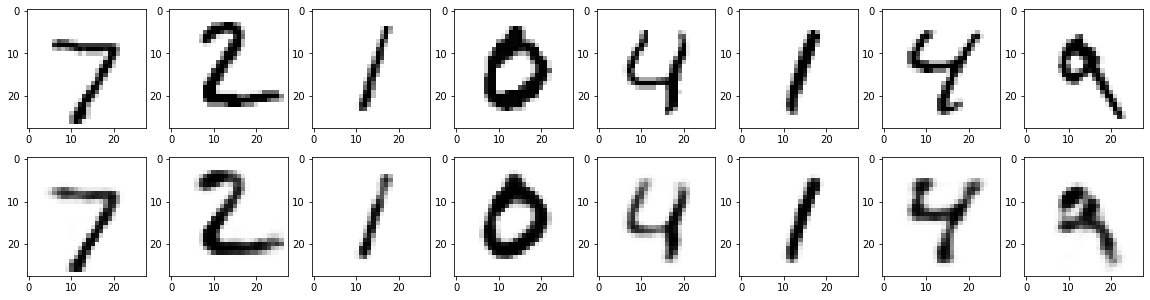

In [0]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  pred = stacked_autoencoder.predict(x_test[i].reshape((1, 28, 28)))
  imshow(x_test[i], cmap="binary")

  subplot(2, 8, i+8+1)
  imshow(pred.reshape((28, 28)), cmap="binary")

Just from this vector:

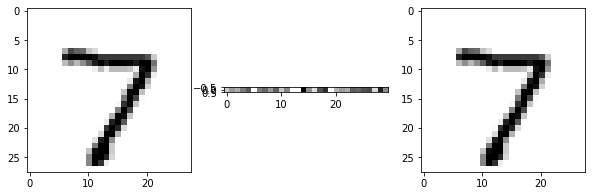

In [0]:
i = 0 # change this number

figsize(10, 5)

subplot(1, 3, 1)
imshow(x_test[i], cmap="binary")

subplot(1, 3, 2)
latent_vector = encoder.predict(x_test[i].reshape((1, 28, 28)))
imshow(latent_vector, cmap="binary")

subplot(1, 3, 3)
pred = decoder.predict(latent_vector)
imshow(x_test[i], cmap="binary")

In [0]:
30 / (28 * 28), 1 - 30 / (28 * 28)

(0.03826530612244898, 0.9617346938775511)

That's 96.2% compression! Pretty amazing, huh?

## Convolutional autoencoder

Apart from data compression, autoencoders can also be used for self-supervised image classification.

The first layers of the encoder learn to recognize patterns in the data very well in order to compress the data. If you don't have access to much labelled data, but a lot of unlabelled data, it's possible to train an autoencoder and copy the first layers from the autoencoder to the classifier network. This can be compared to transfer learning, where you only have to train the head afterwards.

It is well known that convolutional layers are perfect for finding patterns in data, so it's good to know they can also be used in autoencoders. To "de-convolve" images in the decoder, transposed convolutional layers are used. For more information on transposed convolutional layers, checkout [this blog post](https://rickwierenga.com/blog/s4tf/s4tf-gan.html) I have written which explains them in more detail. See the last section "Autoencoders and GANs" of this notebook for more information on the beautiful relation between GANs and autoencoders.

Let's look at a convolutional encoder:

In [0]:
encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2)
])

The weights learnt by this encoder could be copied to the classifier.

In [0]:
encoder.predict(x_test[0].reshape((1, 28, 28))).shape

(1, 3, 3, 64)

Notice how $z \in \mathbb{R}^{1 \times 3 \times 3 \times 64}$. Now we build its counterpart, the decoder, with transposed convolutional layers to recreate a grayscale $28 \times 28$ image.

In [0]:
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding="valid",
                                 activation="relu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="relu"),
    keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [0]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

In [0]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                            optimizer='adam')

In [0]:
history = stacked_autoencoder.fit(x_train, x_train, epochs=10,
                         validation_data=[x_test, x_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 118us/sample - loss: 0.1188 - val_loss: 0.0829
Epoch 2/10
60000/60000 [==============================] - 7s 109us/sample - loss: 0.0803 - val_loss: 0.0768
Epoch 3/10
60000/60000 [==============================] - 7s 110us/sample - loss: 0.0764 - val_loss: 0.0744
Epoch 4/10
60000/60000 [==============================] - 7s 109us/sample - loss: 0.0742 - val_loss: 0.0727
Epoch 5/10
60000/60000 [==============================] - 7s 111us/sample - loss: 0.0727 - val_loss: 0.0719
Epoch 6/10
60000/60000 [==============================] - 7s 108us/sample - loss: 0.0716 - val_loss: 0.0706
Epoch 7/10
60000/60000 [==============================] - 6s 108us/sample - loss: 0.0708 - val_loss: 0.0701
Epoch 8/10
60000/60000 [==============================] - 7s 111us/sample - loss: 0.0702 - val_loss: 0.0691
Epoch 9/10
60000/60000 [==============================] - 7s 110us/sample - loss: 0.06

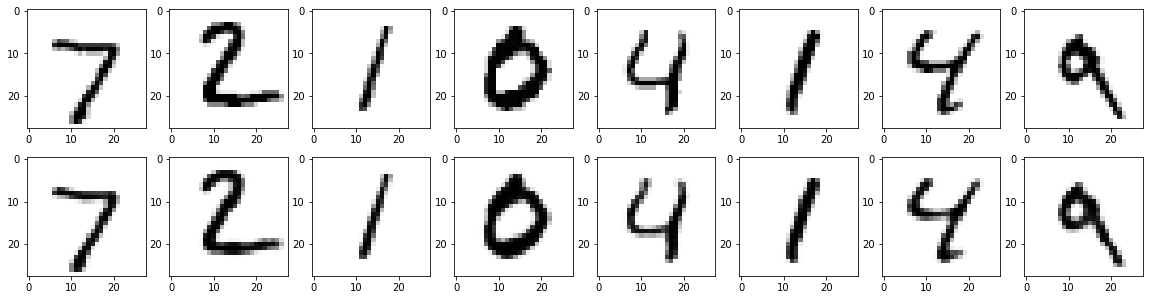

In [0]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  pred = stacked_autoencoder.predict(x_test[i].reshape((1, 28, 28)))
  imshow(x_test[i], cmap="binary")

  subplot(2, 8, i+8+1)
  imshow(pred.reshape((28, 28)), cmap="binary")

Let's look at the weights the encoder learnt. Note that $\sqrt{64} = 8$.

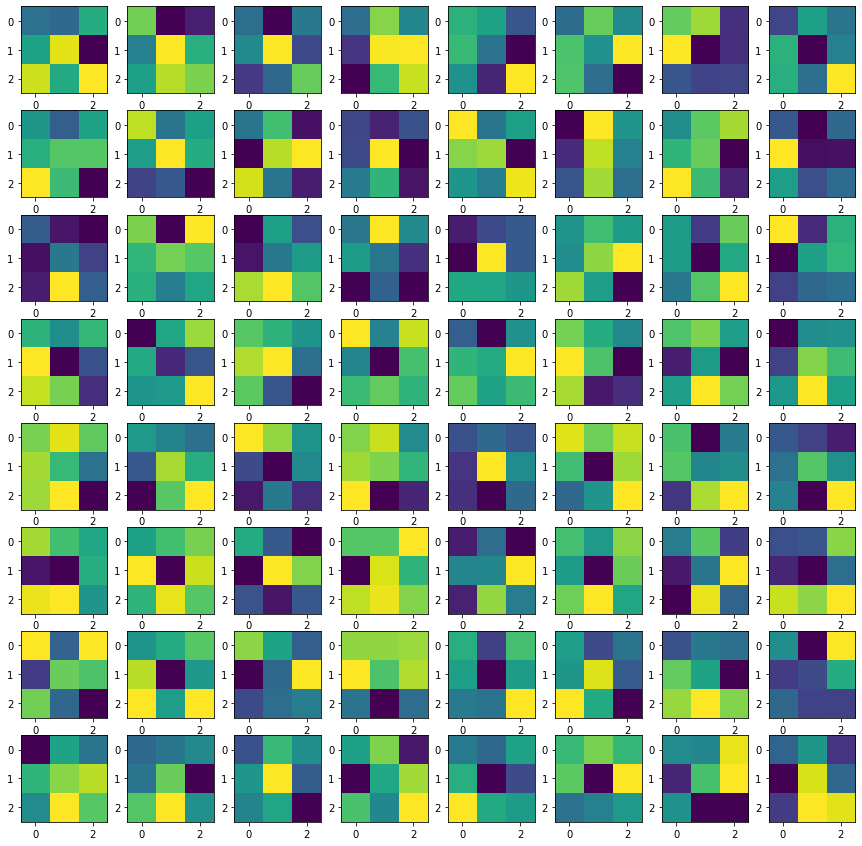

In [0]:
figsize(15, 15)
for i in range(8 * 8):
  subplot(8, 8, i+1)
  imshow(encoder.layers[-2].weights[0][:, :, 0, i])

Visually not very pleasing, but proven to be effective as shown in the previous figure.

$3 \times 3 \times 64=576$ is still less than $28 \times 28 = 784$, thus creating a bottleneck, but much less compressed than the dense encoder making convolutional encoders less suitable for comporession. But thanks to their convolutional layers, they are great to use in cases where you want your autoencoder to find visual patterns in your data.

## Denoising autoencoder

The last application of autoencoders we look at today are denoising autoencoders. You probably have no difficulty classifying the images below as 7's.

In [0]:
import numpy as np

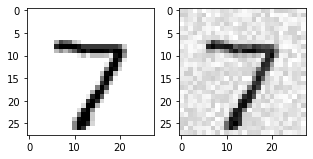

In [0]:
figsize(5, 10)
subplot(1, 2, 1)
imshow(x_test[0], cmap="binary")

subplot(1, 2, 2)
noise = np.random.random((28, 28)) / 4
imshow(x_test[0] + noise, cmap="binary")

But in machine learning, this noise can be catasrophic. Luckily machine learning also has a solution for this problem: auto encoders!

By applying noise to the images inputted to the encoder and setting the clean image as desired output, $y$, an autoencoder can learn to remove noise from the image.

Let's look at such an encoder:

In [0]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(30, activation="relu")
])

In [0]:
decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=[30]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [0]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

In [0]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                            optimizer='adam')

Now create a dataset filled with noise:

In [0]:
x_train_noise = x_train + ((np.random.random(x_train.shape)) / 4)
x_test_noise = x_test + ((np.random.random(x_test.shape)) / 4)

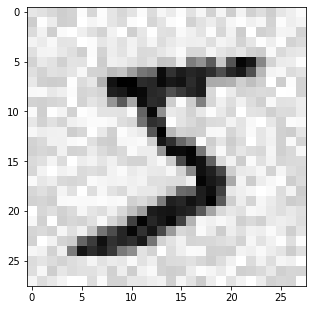

In [0]:
imshow(x_train_noise[0], cmap="binary")

And finally train the stacked autoencoder with noise input data and clean output data.

In [0]:
history = stacked_autoencoder.fit(x_train_noise, x_train, epochs=10,
                                  validation_data=[x_test_noise, x_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 93us/sample - loss: 0.1633 - val_loss: 0.1264
Epoch 2/10
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1206 - val_loss: 0.1130
Epoch 3/10
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1117 - val_loss: 0.1080
Epoch 4/10
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1074 - val_loss: 0.1051
Epoch 5/10
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1049 - val_loss: 0.1031
Epoch 6/10
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1033 - val_loss: 0.1013
Epoch 7/10
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1019 - val_loss: 0.1006
Epoch 8/10
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1004 - val_loss: 0.0987
Epoch 9/10
60000/60000 [==============================] - 5s 87us/sample - loss: 0.0991 - val_

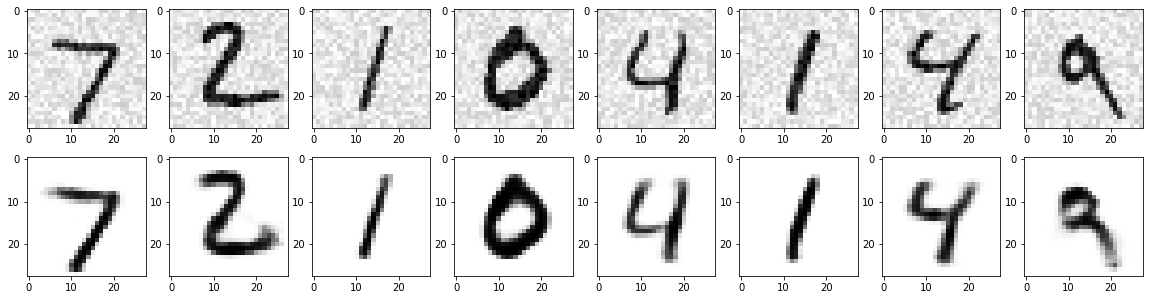

In [0]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  imshow(x_test_noise[i], cmap="binary")

  subplot(2, 8, i+8+1)
  pred = stacked_autoencoder.predict(x_test_noise[i].reshape((1, 28, 28)))
  imshow(pred.reshape((28, 28)), cmap="binary")

Mindblowing!

## Autoencoders and GANs

If you have ever worked with GANs, you have probably noticed some similarities between the generator and decoders by now. Both create images that look like images in the dataset from latent vectors. In fact, the decoder we used for the convolutional auto encoder is one that could be used in DCGANs ([ref](https://rickwierenga.com/blog/s4tf/s4tf-gan.html)).

By encoding training images into latent vectors using an encoder, it's possible to manipulate the output of the generator by manipulating the latent vectors.

* Combining latent vectors of particular training examples into a single latent vector to combine the features of the training examples in a single image.
* That's what researchers at NVIDIA built upon by transitioning latent vectors it's possible to create videos like these:

https://www.youtube.com/watch?v=6E1_dgYlifc

---
made by [@rickwierenga](https://twitter.com/rickwierenga). [GitHub version](https://github.com/rickwierenga/notebooks/blob/master/autoencoders.ipynb)